# Numerical Solutions of Partial Differential Equations

Calculus, particularly Partial Differential Equations (PDEs), has been a cornerstone of mathematical modeling in engineering and science. Over the past century, the theoretical study of PDEs has achieved remarkable success, advancing our understanding of complex phenomena. However, as the demand for precise and detailed quantitative solutions grows, alternative tools have become necessary to meet the needs of practitioners.

The advent of modern computing in the 1950s revolutionized the field, making the numerical simulation of PDEs a feasible and practical approach. Over the last 70 years, a wide range of algorithms has been developed for this purpose, offering speed, robustness, and accuracy. Key methods include:

1. Finite Difference Methods
2. Finite Element Methods
3. Spectral Element Methods
4. Boundary Integral/Element Methods

Despite significant achievements in creating robust and adaptable solvers for a wide variety of problems, the pursuit of faster, more efficient techniques remains ongoing. Recently, practitioners have begun exploring machine learning-based solvers as a promising new approach to tackle increasingly complex and subtle challenges in the field.

# Physics-Informed Neural Networks

The material and images in this section are influenced by material in Ben Moseley's [blog](https://benmoseley.blog/).

Machine learning is gaining traction in scientific disciplines, but can these algorithms truly “understand” the scientific problems they aim to solve? This notebook provides a brief overview of physics-informed neural networks (PINNs), a powerful technique that integrates physical laws into machine learning models, thereby combining empirical data with scientific principles.


## Machine Learning in Science

Machine learning has brought about a paradigm shift in scientific methodology. Traditionally, scientific research has relied on the iterative refinement of theories through experimental data. In this approach, a well-defined theoretical model is tested and modified as new experimental results emerge, guiding further predictions.

With the rapid development of machine learning technologies and the increasing availability of data, data-driven approaches have become prevalent. In this framework, a pre-existing theory is not a prerequisite. Instead, machine learning algorithms are trained on data to analyze a scientific problem without explicit reliance on theoretical constructs.


## Learning to model experimental data

One way in which machine learning can be applied in scientific research is by modeling experimental data. Consider an example where experimental data points represent an unknown physical phenomenon, such as the orange points in the animation below.

![](https://benmoseley.blog/wp-content/uploads/2021/08/nn.gif)

A popular method for this task is the use of a neural network. Given the position of a data point $x$, a neural network can be used to predict its corresponding value $u$, as illustrated in the figure below.

![size=0.7](https://benmoseley.blog/wp-content/uploads/2021/08/nn.png)

To train the network, its free parameters $(\theta_j)$ are adjusted so that the predictions closely align with the provided data. This is typically achieved by minimizing the mean squared error (MSE) between the network's predictions and the true data values:

$$ \underset{\text{Mean-Square Error}}{\min \underbrace{\frac{1}{N}\sum_i^N \left(u_{NN}(x_i;\theta) - u_{\text{true}}(x_i)\right)^2}}. $$

After training, the network can fit the experimental data, as shown in the animation.

## Limitations of purely data-driven approaches

While data-driven methods can be effective within the range of available data, they often struggle to generalize beyond the training data. For example, in the animation above, the grey line represents the actual values of the physical process that generated the experimental data. It is evident that the neural network performs well near the training data but fails to capture the true behavior of the system in regions without data. This limitation reveals that a purely data-driven approach may not fully capture the underlying scientific phenomena.


## The rise of scientific machine learning (SciML)

Now, consider that we have prior knowledge about the physical process governing the data. Specifically, the data points correspond to the position of a damped harmonic oscillator, a well-known problem in physics.

![](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif)

The dynamics of this system can be described by the following second-order differential equation:

$$ m\frac{d^2 u}{dx^2} + \mu \frac{du}{dx} + ku = 0 $$

where $m$ represents the mass of the oscillator, $\mu$ is the damping coefficient, and $k$ is the spring constant. Recognizing the limitations of purely data-driven models, researchers are now integrating such prior scientific knowledge into machine learning workflows, leading to the development of scientific machine learning (SciML) approaches. These approaches aim to combine data with well-established physical principles.


## So, what exactly is a physics-informed neural network?

A *physics-informed neural network (PINN)* provides a way to incorporate known physical laws, such as differential equations, directly into the neural network's training process. The concept is straightforward: in addition to minimizing the error between predictions and data, we also introduce the governing physical equations into the network's loss function.

The process begins by sampling a set of input locations ($x_j$) and passing them through the neural network. The gradients of the network's output with respect to its inputs are computed (using techniques such as [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)), and these gradients are used to calculate the residuals of the differential equation. This residual is then added to the loss function as a *physics-based regularization term*.

![size=0.8](https://benmoseley.blog/wp-content/uploads/2021/08/pinn.png)

For the damped harmonic oscillator, this leads to a loss function of the form:

$$ \underset{\text{Mean-Square Error}}{\min \underbrace{\frac{1}{N}\sum_i^N \left(u_{NN}(x_i;\theta) - u_{\text{true}}(x_i)\right)^2}} + \underset{\text{Physical Loss}}{\underbrace{\frac{1}{M}\sum_j^M \left(\left[m\frac{d}{dx^2} + \mu \frac{d}{dx} + k\right]u_{NN}(x_j;\theta)\right)^2}} $$

This additional term ensures that the neural network's learned solution adheres to the physical constraints imposed by the known differential equation.

## Remarks

By incorporating physical laws into the training process, PINNs can generalize better to regions where no data is available, as demonstrated in the case of the damped harmonic oscillator. The physics-informed model is capable of accurately predicting the system's behavior far from the experimental data points, outperforming purely data-driven models.

The poor performance of the naive network can be attributed to its reliance on data alone, effectively ignoring the wealth of existing scientific knowledge. In contrast, the PINN leverages this knowledge, leading to superior predictive accuracy.

PINNs are broadly applicable to any problem governed by differential equations, making them a versatile tool in scientific machine learning. For more information, one can explore the growing field of [scientific machine learning (SciML)](https://www.osti.gov/biblio/1478744) and the role of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) in neural network training.


# 1D Example: Damped Oscillator with Sinusoidal Forcing

Suppose we are given:

 $$\begin{cases}
 \dfrac {dy} {dt} + 0.1 y - \sin\left(\dfrac{\pi t}{2}\right) = 0,& ~t\in[0,30]\\
 y(0)=1,& ~\text{at}~ t=0
 \end{cases}$$

and would like to use PINNs on this problem. We will first setup our environment.

In [1]:
%%capture
!conda create -n pinn python=3
!conda activate pinn
!conda install jupyter numpy matplotlib
!conda install pytorch torchvision torchaudio -c pytorch
!pip install ipywidgets

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets
import pylab as pl
from IPython import display
from IPython.display import clear_output

In [3]:
def oscillatorb():
    """
    Simulates a damped oscillator using a second-order trapezoidal integration scheme.

    The oscillator is simulated over a time interval [0, 30] with damping and sinusoidal forcing.
    The integration is done using a time step determined by the number of steps specified (3000).

    Returns
    -------
    tPoints : torch.Tensor
        Time points for the simulation (shape: [n_steps, 1]).
    y : torch.Tensor
        State variable (displacement) at each time step (shape: [n_steps, 1]).
    """
    nSteps=3000              # Number of time steps
    tMin,tMax = 0.0,30.0      # Time domain
    tStep = (tMax-tMin)/nSteps   # Time step
    tPoints = np.arange(tMin, tMax, tStep) # Array of time points

    # Set initial conditions for the state variables
    y0 = 1.0
    y = [y0] # Initialize displacement

    # Solve forward in time
    for t in tPoints[1:]:
        tdemi= t - tStep/2 # Midpoint time
        # Estimate the value of y at the midpoint using the previous state
        ydemi = y[-1] + tStep/2*( - 0.1*y[-1] + np.sin(np.pi*tdemi/2))
        # Compute the next state using the midpoint estimate
        y.append(y[-1] + tStep * (- 0.1*ydemi + np.sin(np.pi*t/2)))

    y = torch.Tensor(y)

    return torch.Tensor(tPoints).view(-1, 1), torch.Tensor(y).view(-1, 1)


class FCN(nn.Module):
    """
    Fully Connected Neural Network (FCN).

    Parameters
    ----------
    N_INPUT : int
        The number of input features.
    N_OUTPUT : int
        The number of output features.
    N_HIDDEN : int
        The number of hidden units per layer.
    N_LAYERS : int
        The number of hidden layers in the network.
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        # First fully connected layer with input and hidden units
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        # Stack of hidden layers
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN),
                                   activation()]) for _ in range(N_LAYERS-1)])
        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after passing through the network.
        """
        x = self.fcs(x) # Apply the first layer
        x = self.fch(x) # Pass through the hidden layers
        x = self.fce(x) # Output layer
        return x

Then we will generate training data.

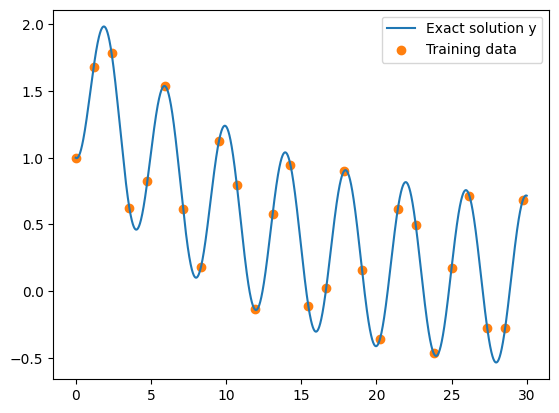

In [4]:
# Exact solution and training data
x, y = oscillatorb()
x = x[::1]
y = y[::1]
x_data=x[0:3000:119]
y_data=y[0:3000:119]


plt.figure()
plt.plot(x, y, label="Exact solution y")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

Next, let's try using a fully connected neural network to fit the training points. We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [5]:
# First training setup with FCN
def plot_result_NN(x, y, x_data, y_data, yh, step=None):
    """
    Plots the training results of the neural network against the exact solution.

    Parameters
    ----------
    x : array-like
        Time points for the solution (shape: [n_points, 1]).
    y : array-like
        Exact solution at each time point (shape: [n_points, 1]).
    x_data : array-like
        Time points for the training data (shape: [n_data_points, 1]).
    y_data : array-like
        Training data values (shape: [n_data_points, 1]).
    yh : array-like
        Neural network prediction at each time point (shape: [n_points, 1]).
    step : int, optional
        Current training step (default is None).
    """
    plt.figure(figsize=(8, 4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x, y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if step is not None:
        plt.text(2.965, 1.90, f"Training step: {step}", fontsize="xx-large", color="k")
    plt.legend(loc=(0.67, 0.62), frameon=False, fontsize="large")
    plt.ylabel('y', fontsize="xx-large")
    plt.xlabel('Time', fontsize="xx-large")
    plt.axis("on")

# Function to update plot based on the slider value for NN
def update_plot_NN(step):
    """
    This function clears the current figure and updates the plot with the
    corresponding prediction at the specified training step.

    Parameters
    ----------
    step : int
        The current step number to update the plot.
    """
    plt.clf()
    yh = predictionsNN[step // 5000][1]  # Get the prediction for the current step
    plot_result_NN(x, y, x_data, y_data, yh, step=step)
    plt.show()

# Training setup
torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

# Store loss and prediction history
lossNN_history = []
predictionsNN = []

for i in range(40000):
    optimizer.zero_grad() # Zero out the gradients
    yh = model(x_data)

     # Compute the loss using mean squared error
    loss = torch.mean((yh - y_data) ** 2)
    loss.backward() # Backpropagate the loss
    optimizer.step() # Update the model parameters

    # Store loss every 100 iterations and predictions every 5000 iterations
    if (i + 1) % 100 == 0:
        lossNN_history.append(loss.detach())
        if (i + 1) % 5000 == 0:
            predictionsNN.append((i + 1, model(x).detach().numpy()))

# Create a slider for playback with increments of 5000
steps = [step for step, _ in predictionsNN]  # Extract step numbers
slider = widgets.IntSlider(value=0, min=0, max=len(predictionsNN) * 5000 - 1, step=5000, description='Training step')
widgets.interactive(update_plot_NN, step=slider)

interactive(children=(IntSlider(value=0, description='Training step', max=39999, step=5000), Output()), _dom_c…

We also examine the training loss.

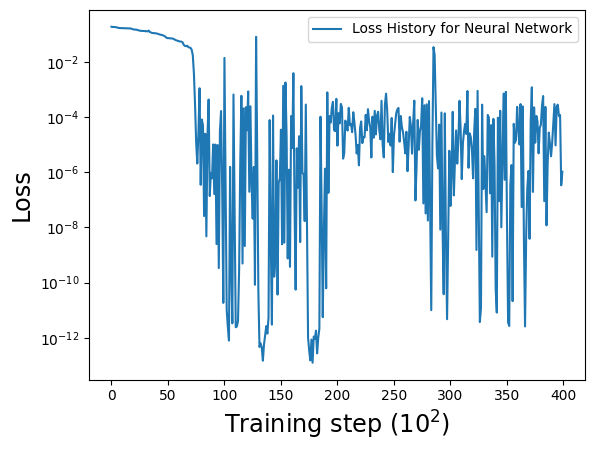

In [6]:
fig11 = plt.figure()
plt.plot(lossNN_history, label='Loss History for Neural Network')
plt.xlabel('Training step ($10^2$)', fontsize="xx-large")
plt.ylabel('Loss', fontsize="xx-large")
plt.yscale('log')
plt.legend()
plt.show()

Next, let's do the same procedure with a PINN. The physical loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

In [7]:
# Second training setup with collocation points
def plot_result_collocation(x, y, x_data, y_data, yh, xp=None, step=None):
    """
    Plots the training results for the neural network when using collocation points.

    Parameters
    ----------
    x : array-like
        Time points for the exact and predicted solutions (shape: [n_points, 1]).
    y : array-like
        Exact solution values at each time point (shape: [n_points, 1]).
    x_data : array-like
        Time points for the training data (shape: [n_data_points, 1]).
    y_data : array-like
        Training data values at each time point (shape: [n_data_points, 1]).
    yh : array-like
        Neural network predicted solution at each time point (shape: [n_points, 1]).
    xp : array-like, optional
        Collocation points used in the training (shape: [n_collocation_points, 1]).
    step : int, optional
        Current training step to be displayed on the plot (default is None).
    """
    plt.figure(figsize=(8, 4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x, y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0 * torch.ones_like(xp), s=30, color="tab:green", alpha=0.4,
                    label='Collocation points')
    leg = plt.legend(loc=(0.67, 0.62), frameon=False, fontsize="large")
    plt.setp(leg.get_texts(), color="k")
    plt.xlim(-1.25, 31.05)
    plt.ylim(-0.65, 2.25)
    if step is not None:
        plt.text(2.965, 1.90, f"Training step: {step}", fontsize="xx-large", color="k")
    plt.ylabel('y', fontsize="xx-large")
    plt.xlabel('Time', fontsize="xx-large")
    plt.axis("on")

def update_plot_collocation(step):
    """
    Updates the plot based on the current training step of the collocation point
    method.

    Parameters
    ----------
    step : int
        The current training step to be visualized.
    """
    plt.clf()  # Clear the current figure
    step_index = step // 5000
    if step_index < len(predictions):
        _, yh, xp = predictions[step_index]  # Get prediction and collocation points
        plot_result_collocation(x, y, x_data, y_data, yh, xp, step=step)
        plt.show()

# Collocation training setup
col_pts = torch.linspace(0, 30, 50).view(-1, 1).requires_grad_(True)  # Sample locations over the domain
lam = 0.1

# Store loss history and predictions
loss_history = []
loss2_history = []
predictions = []

for i in range(40000):
    optimizer.zero_grad() # Zero out the gradients

    # Compute the data loss (MSE between predicted and actual data)
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data) ** 2)  # Use mean squared error

    # Compute the physical loss (PDE residual)
    yhp = model(col_pts)
    dx = torch.autograd.grad(yhp, col_pts, torch.ones_like(yhp), create_graph=True)[0]
    residual = (dx + lam * yhp - torch.sin(np.pi * col_pts / 2))
    loss2 = (6e-2) * (torch.mean(residual ** 2))

    # Combine the data and physical loss
    loss = loss1 + loss2 # Total loss = data loss + physical loss
    loss.backward() # Backpropagate the total loss
    optimizer.step() # Update the model parameters

    # Store loss every 100 iterations and predictions every 5000 iterations
    if (i + 1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())

        if (i + 1) % 5000 == 0:
            yh = model(x).detach()
            xp = col_pts.detach()
            predictions.append((i + 1, yh, xp))

# Create a slider for playback with increments of 5000
slider2 = widgets.IntSlider(value=0, min=0, max=len(predictions) * 5000 - 1, step=5000, description='Training step')
widgets.interactive(update_plot_collocation, step=slider2)

interactive(children=(IntSlider(value=0, description='Training step', max=39999, step=5000), Output()), _dom_c…

We then examine the training loss from the data loss and physical loss.

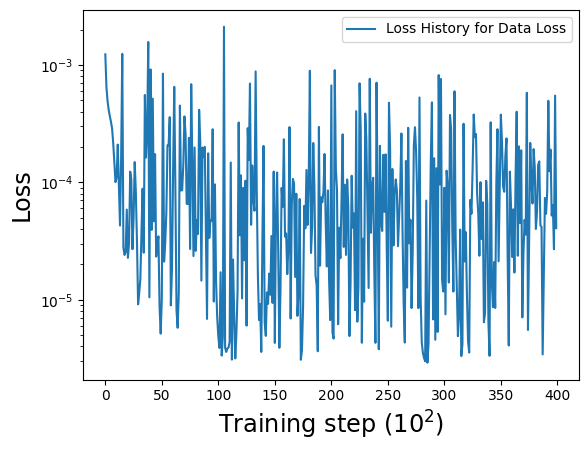

In [8]:
fig12 = plt.figure()
plt.plot(loss_history, label='Loss History for Data Loss')
plt.xlabel('Training step ($10^2$)', fontsize="xx-large")
plt.ylabel('Loss', fontsize="xx-large")
plt.yscale('log')
plt.legend()
plt.show()

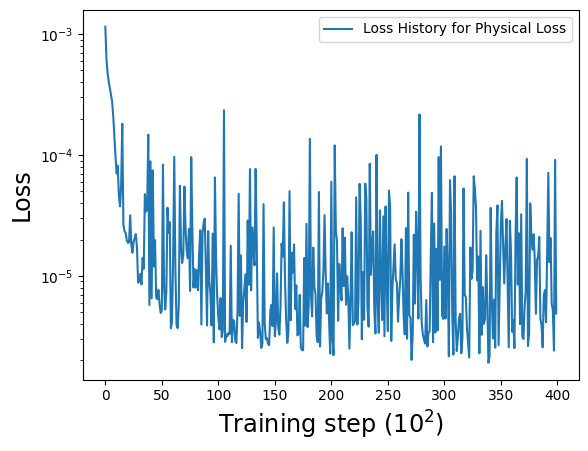

In [9]:
fig13 = plt.figure()
plt.plot(loss2_history, label="Loss History for Physical Loss")
plt.xlabel('Training step ($10^2$)', fontsize="xx-large")
plt.ylabel('Loss', fontsize="xx-large")
plt.yscale('log')
plt.legend()
plt.show()

# 2D Example

We now examine the 2D Helmholtz Boundary Value Problem:

 $$\begin{cases}
 \Delta u + k^2 u = 0, &~\text{in} ~\tilde{\Omega} \\
 u(x)=g(x), &~\text{on}~\partial\tilde{\Omega}
 \end{cases}$$

 where $x=(x_1,x_2)\in\mathbb R^2$, $~\tilde{\Omega}\subset\mathbb R^2$ is bounded, and $k$ is the wave number.

We will start by importing the necessary libraries.

In [11]:
%%capture
!pip install pyDOE

In [13]:
import numpy as np
import torch
import torch.autograd as autograd         # Computation graph
from torch import Tensor                  # Tensor node in the computation graph
import torch.nn as nn                     # Neural networks
import torch.optim as optim               # Optimizers for gradient descent, ADAM, etc.
import time
from pyDOE import lhs                     # Latin Hypercube Sampling
import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')

plt.ion()  # Enable interactive mode

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(1234)

# NumPy random number generator
np.random.seed(1234)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


Next, we create some helper functions to setup training and test data.

In [14]:
def create_grid(num_grid_pts=256, n_dim=2):
    """
    Creates an n-dimensional grid of points as a NumPy array.

    Parameters
    ----------
    num_grid_pts : int, optional
        The number of grid points along each dimension (default is 256).
    n_dim : int, optional
        The number of dimensions (default is 2).

    Returns
    -------
    grid : np.ndarray
        n-dimensional grid points as a NumPy array.
    axis_points : list of np.ndarray
        List of 1D arrays of points for every dimension.
    """
    # Form 1D arrays for every dimension
    axis_points = [np.linspace(0, np.pi, num_grid_pts) for _ in range(n_dim)]

    # Generate a meshgrid up to n_dim
    grids = np.meshgrid(*axis_points, indexing='ij', sparse=False)

    return grids, axis_points


def prepare_test_data(X, Y):
    """
    Prepare test data by flattening the 2D grids and stacking them column-wise.

    Parameters
    ----------
    X : np.ndarray
        2D grid points in the x-dimension as a NumPy array.
    Y : np.ndarray
        2D grid points in the y-dimension as a NumPy array.

    Returns
    -------
    X_u_test : np.ndarray
        Test data prepared by stacking the flattened x and y grids.
    lb : np.ndarray
        Lower bound for the domain (boundary conditions).
    ub : np.ndarray
        Upper bound for the domain (boundary conditions).
    """
    # Flatten the grids and stack them into a 2D array
    X_u_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

    # Domain bounds as NumPy arrays
    lb = np.array([0, 0], dtype=np.float32)
    ub = np.array([np.pi, np.pi], dtype=np.float32)

    return X_u_test, lb, ub


def prepare_training_data(N_u, N_f, lb, ub, usol, X, Y):
    """
    Prepare boundary condition data and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary condition points to select.
    N_f : int
        Number of collocation points for the physics-informed model.
    lb : np.ndarray
        Lower bound for the domain.
    ub : np.ndarray
        Upper bound for the domain.
    usol : np.ndarray
        Analytical solution of the PDE.
    X : np.ndarray
        X grid of points.
    Y : np.ndarray
        Y grid of points.

    Returns
    -------
    X_f_train : np.ndarray
        Collocation points in the domain.
    X_u_train : np.ndarray
        Boundary condition points.
    u_train : np.ndarray
        Corresponding boundary condition values.
    """
    # Boundary points from all four edges
    boundary_points = np.vstack((
        np.hstack((X[:, 0][:, None], Y[:, 0][:, None])),
        np.hstack((X[:, -1][:, None], Y[:, -1][:, None])),
        np.hstack((X[0, :][:, None], Y[0, :][:, None])),
        np.hstack((X[-1, :][:, None], Y[-1, :][:, None]))
    ))

    # Boundary values (analytical solution at boundary points)
    boundary_values = np.vstack((
        usol[:, 0][:, None],
        usol[:, -1][:, None],
        usol[0, :][:, None],
        usol[-1, :][:, None]
    ))

    # Randomly select N_u boundary points
    idx = np.random.choice(boundary_points.shape[0], N_u, replace=False)
    X_u_train = boundary_points[idx, :]
    u_train = boundary_values[idx, :]

    # Generate N_f collocation points using Latin Hypercube Sampling
    X_f_train = lb + (ub - lb) * lhs(2, N_f)  # Collocation points in [lb, ub]

    return X_f_train, X_u_train, u_train

We then define the Pytorch class for the Helmholtz PINN.

In [15]:
class HelmholtzPINN(nn.Module):
    """
    A neural network for solving data (boundary condition) loss and partial
    differential equation (residual) loss for the 2D Helmholtz equation in PyTorch.

    Parameters
    ----------
    layers : list
        A list defining the number of nodes in each layer of the network.
    """

    def __init__(self, layers):
        """
        Initializes the SequentialModel with the specified layers, activation function,
        loss function, and weight initialization.

        Parameters
        ----------
        layers : list
            A list of integers where each element defines the number of neurons
            in the respective layer.
        """
        super().__init__()

        # LeakyReLU activation function
        self.activation = nn.LeakyReLU()

        # Mean squared error (MSE) loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        # L1 loss (mean absolute error) function
        self.l1loss_function = nn.L1Loss(reduction='mean')

        # Initialize the network as a list of linear layers
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        # Xavier normal initialization for weights and setting biases to zero
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        """
        Forward pass through the network. Scales the input features and passes them through
        the layers of the model, applying the activation function after each layer.

        Parameters
        ----------
        x : torch.Tensor or numpy array
            Input tensor or array to be processed.

        Returns
        -------
        torch.Tensor
            Output of the model.
        """
        # Convert numpy array to tensor if needed
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        # Convert lower and upper bounds to tensors
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        # Feature scaling
        x = (x - l_b) / (u_b - l_b)

        # Convert input to float
        a = x.float()

        # Pass through each linear layer with activation
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)

        # Final layer without activation
        a = self.linears[-1](a)

        return a

    def loss_PDE(self, x_to_train_f, k):
        """
        Computes the partial differential equation (PDE) loss using automatic differentiation
        to calculate the second-order derivatives.

        Parameters
        ----------
        x_to_train_f : torch.Tensor
            Input tensor for training PDE.
        k : int
            Wave number of the Helmholtz equation.

        Returns
        -------
        torch.Tensor
            Loss value for the PDE.
        """
        x_1_f = x_to_train_f[:, [0]]
        x_2_f = x_to_train_f[:, [1]]

        g = x_to_train_f.clone()
        g.requires_grad = True

        # Forward pass through the network
        u = self.forward(g)

        # Compute first-order derivatives
        u_x = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to(device),
                            retain_graph=True, create_graph=True)[0]

        # Compute second-order derivatives
        u_xx = autograd.grad(u_x, g, torch.ones(x_to_train_f.shape).to(device),
                             create_graph=True)[0]
        u_xx_1 = u_xx[:, [0]]
        u_xx_2 = u_xx[:, [1]]

        # Define the PDE residual
        q = k**2 * torch.sin(n * x_1_f) * torch.sin(m * x_2_f)
        f = u_xx_1 + u_xx_2 + k**2 * u - q

        # PDE loss
        return self.loss_function(f, f_hat)

    def test(self, X_test, u_true):
        """
        Test the model on the test data and computes the relative L2 norm of the error and the mean absolute error.

        Parameters
        ----------
        X_test : torch.Tensor
            Test points across the domain.
        u_true : torch.Tensor
            True solution values (ground truth) for comparison.

        Returns
        -------
        error_vec : torch.Tensor
            The relative L2 norm of the error.
        u_pred : numpy.ndarray
            The predicted solution.
        mae : torch.Tensor
            Mean absolute error between the predictions and the true values.
        """
        # Model prediction
        u_pred = self.forward(X_test)

        # Compute the relative L2 norm of the error
        error_vec = torch.linalg.norm(u_true - u_pred, 2) / torch.linalg.norm(u_true, 2)

        # Compute the mean absolute error (MAE)
        mae = torch.mean(torch.abs(u_true - u_pred))

        # Reshape the predicted output
        u_pred = np.reshape(u_pred.cpu().detach().numpy(), (num_grid_pts, num_grid_pts), order='F')

        return error_vec, u_pred, mae

We also define some training and plotting functions.

In [16]:
def LBFGS_training():
    """
    Computes the loss and its gradients for use with the LBFGS optimizer.

    Necessary for optimizers which require multiple evaluations of the function. It performs the following:
    - Resets gradients to zero.
    - Calculates the loss using the physics-informed neural network (PINN) model.
    - Backpropagates the gradients of the loss.

    Returns
    -------
    loss : torch.Tensor
        The computed loss value.
    """
    # Zero out the gradients of the optimizer before backpropagation
    lbfgs_optimizer.zero_grad()

    # Forward pass for boundary condition points
    u_pred_train = PINN.forward(X_u_train)

    # Data loss (MSE between predicted and true boundary condition values)
    data_loss = PINN.loss_function(u_pred_train, u_train)

    # Physics loss (PDE residuals)
    physics_loss = PINN.loss_PDE(X_f_train, k)

    # Total loss: sum of data loss and physics loss
    total_loss = data_loss + physics_loss

    # Perform backpropagation to compute the gradients of the loss
    total_loss.backward()

    # Return the total loss value to the optimizer
    return total_loss


def plot_training_progress(train_losses, test_losses, train_maes, test_maes, steps):
    """
    Plot the training and test losses, along with the train and test MAEs, over the course of training.

    Parameters
    ----------
    train_losses : list
        List of training loss values recorded at each training step.
    test_losses : list
        List of test loss values recorded at each evaluation step.
    train_maes : list
        List of train MAE values recorded during training.
    test_maes : list
        List of test MAE values recorded during training.
    steps : list
        List of step numbers corresponding to the recorded losses and metrics.

    Returns
    -------
    None
    """
    plt.figure(figsize=(12, 8))

    # Plot training loss
    plt.plot(steps, train_losses, label='Train Loss (MSE)', color='blue', linestyle='-', marker='o')

    # Plot test loss
    plt.plot(steps, test_losses, label='Test Loss (MSE)', color='red', linestyle='--', marker='x')

    # Plot train MAE
    plt.plot(steps, train_maes, label='Train MAE', color='green', linestyle='-.', marker='s')

    # Plot test MAE
    plt.plot(steps, test_maes, label='Test MAE', color='orange', linestyle=':', marker='d')

    plt.xlabel('Steps', fontsize="x-large")
    plt.ylabel('MSE / MAE', fontsize="x-large")
    plt.legend()
    plt.title('Training Progress: MSE and MAE')

    plt.tight_layout()
    plt.yscale('log')
    plt.show()
    plt.pause(0.1)
    plt.savefig('training_progress.png', dpi=500, bbox_inches='tight')


def solutionplot(u_pred, usol, x_1, x_2, index, X_f_train=None):
    """
    Plots the ground truth solution, predicted solution, and absolute error between them.
    Optionally includes the collocation points.

    Parameters
    ----------
    u_pred : numpy.ndarray
        Predicted solution values from the model.
    usol : numpy.ndarray
        Ground truth solution values to be plotted.
    x_1 : numpy.ndarray
        1D array of grid points in the x1-dimension.
    x_2 : numpy.ndarray
        1D array of grid points in the x2-dimension.
    index : int
        Current iteration of the optimizer.
    X_f_train : torch.Tensor, optional
        Collocation points used for PDE loss (optional, default is None).
    """

    plt.figure(figsize=(18, 5))

    # Plot ground truth solution
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Plot predicted solution
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(f'Predicted $\hat u(x_1,x_2)$ - Iteration {index}', fontsize=15)

    # Optionally plot collocation points
    if X_f_train is not None:
        X_f_train_np = X_f_train.cpu().numpy()
        plt.scatter(X_f_train_np[:, 0], X_f_train_np[:, 1], color='white', s=1, label="Collocation Points")
        plt.legend()

    # Plot absolute error
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)

    plt.tight_layout()
    plt.show()
    plt.pause(0.1)
    plt.savefig(f'Helmholtz_iter_{index}.png', dpi=500, bbox_inches='tight')

We then train our Helmholtz PINN over the unit square.

HelmholtzPINN(
  (activation): LeakyReLU(negative_slope=0.01)
  (loss_function): MSELoss()
  (l1loss_function): L1Loss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1-3): 3 x Linear(in_features=200, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


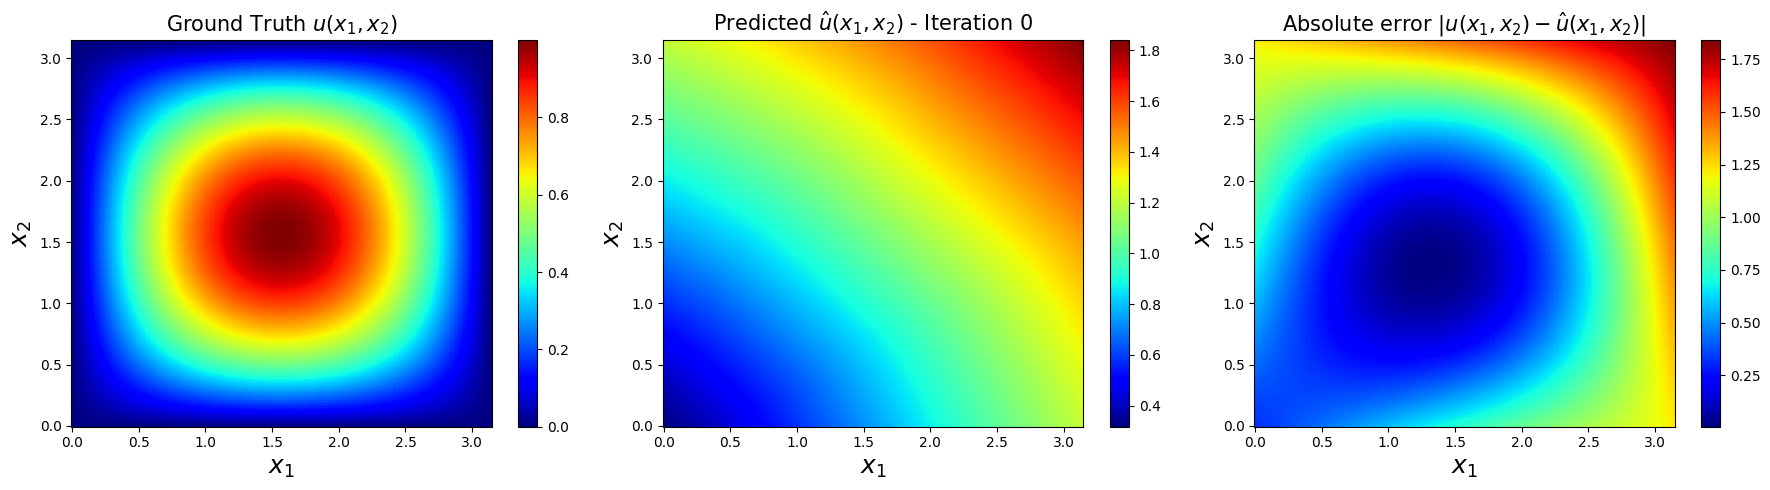

<Figure size 640x480 with 0 Axes>

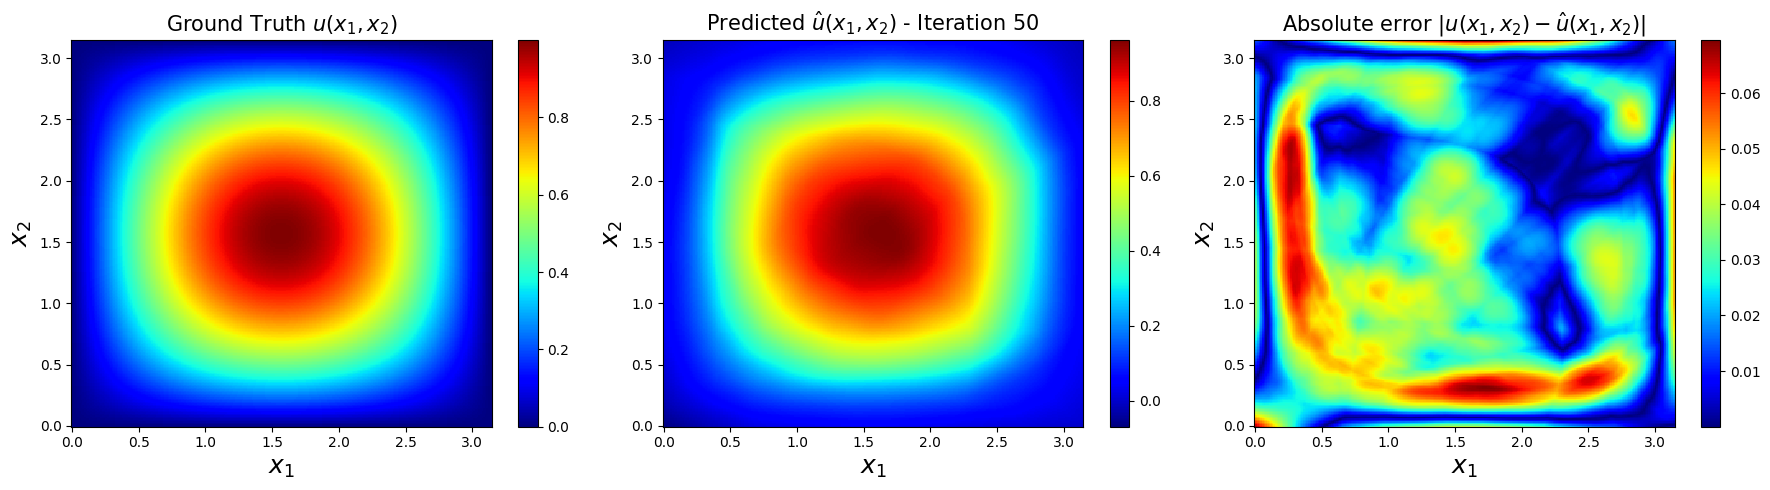

<Figure size 640x480 with 0 Axes>

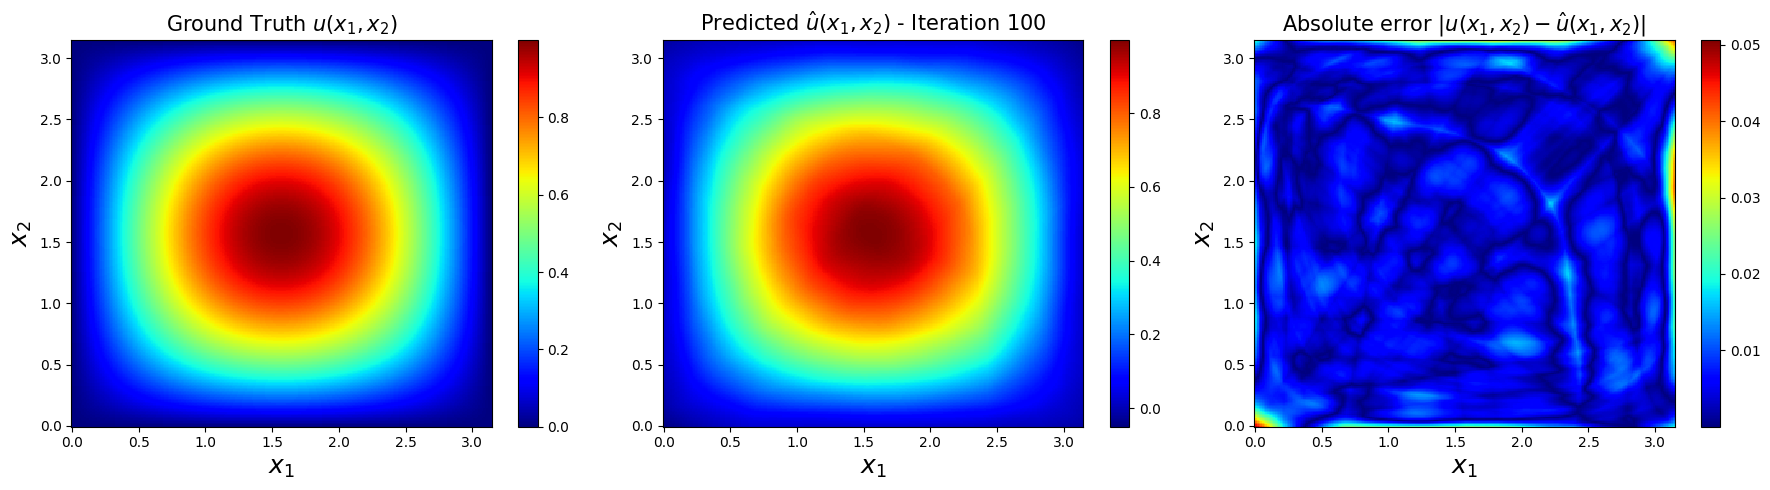

<Figure size 640x480 with 0 Axes>

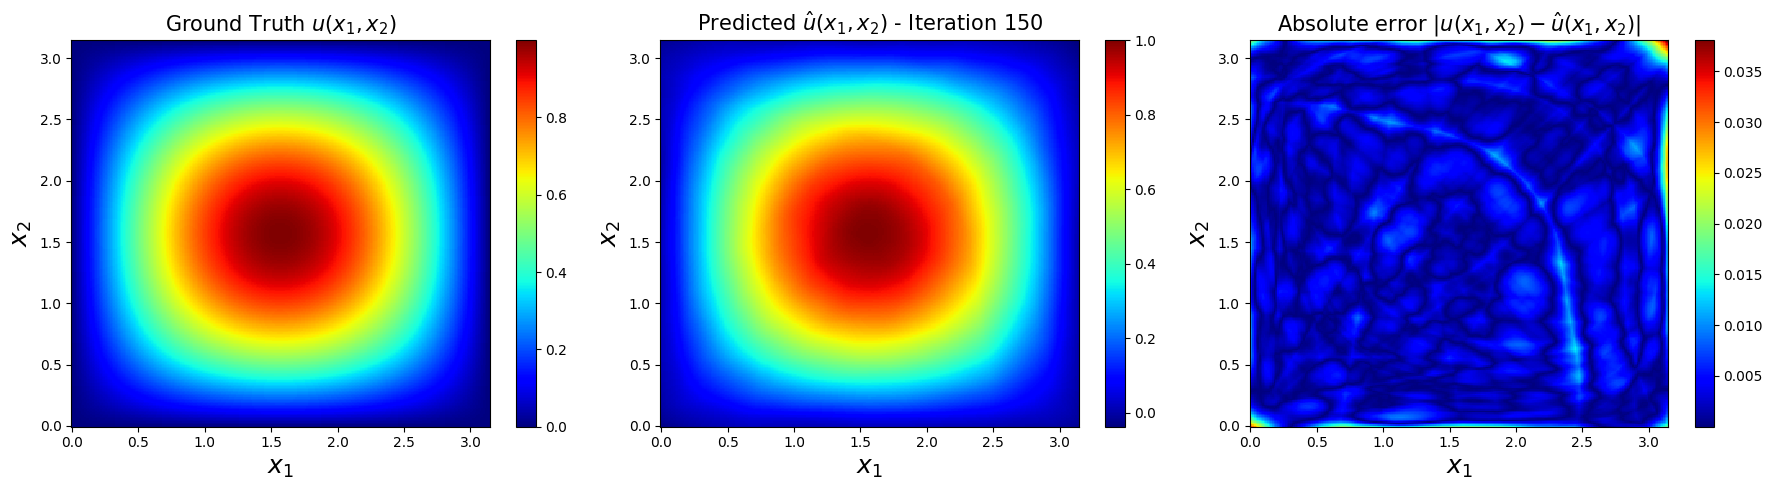

<Figure size 640x480 with 0 Axes>

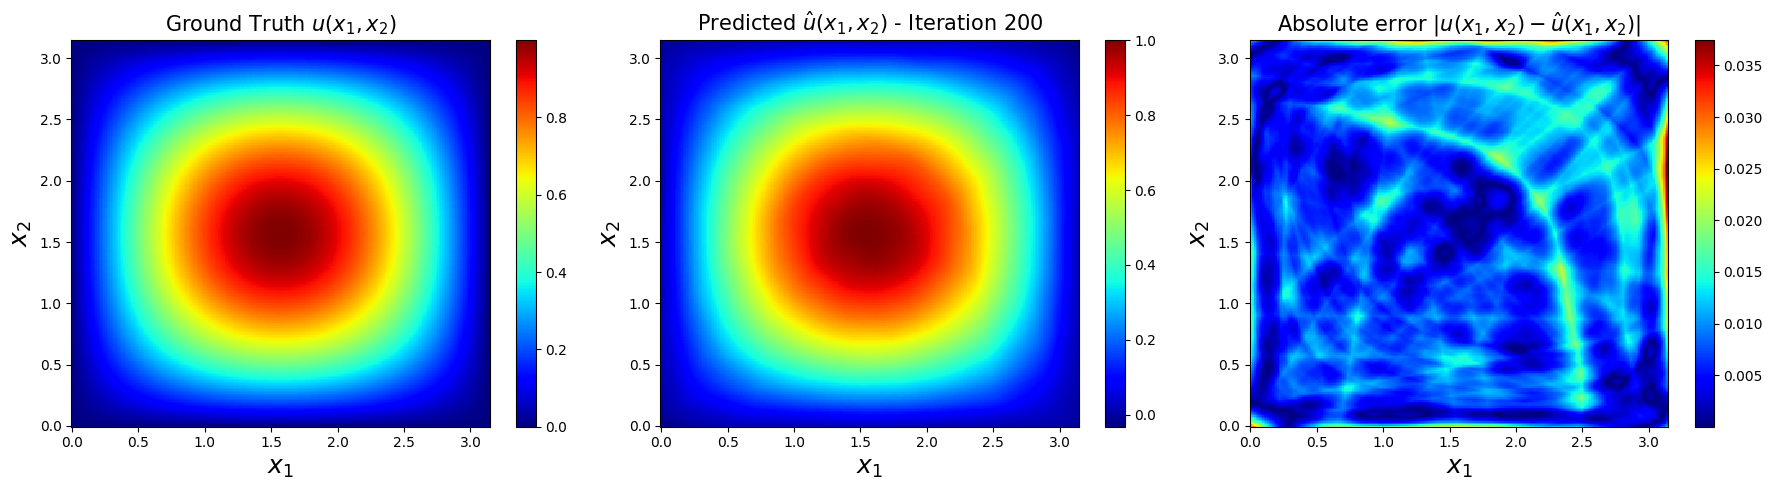

<Figure size 640x480 with 0 Axes>

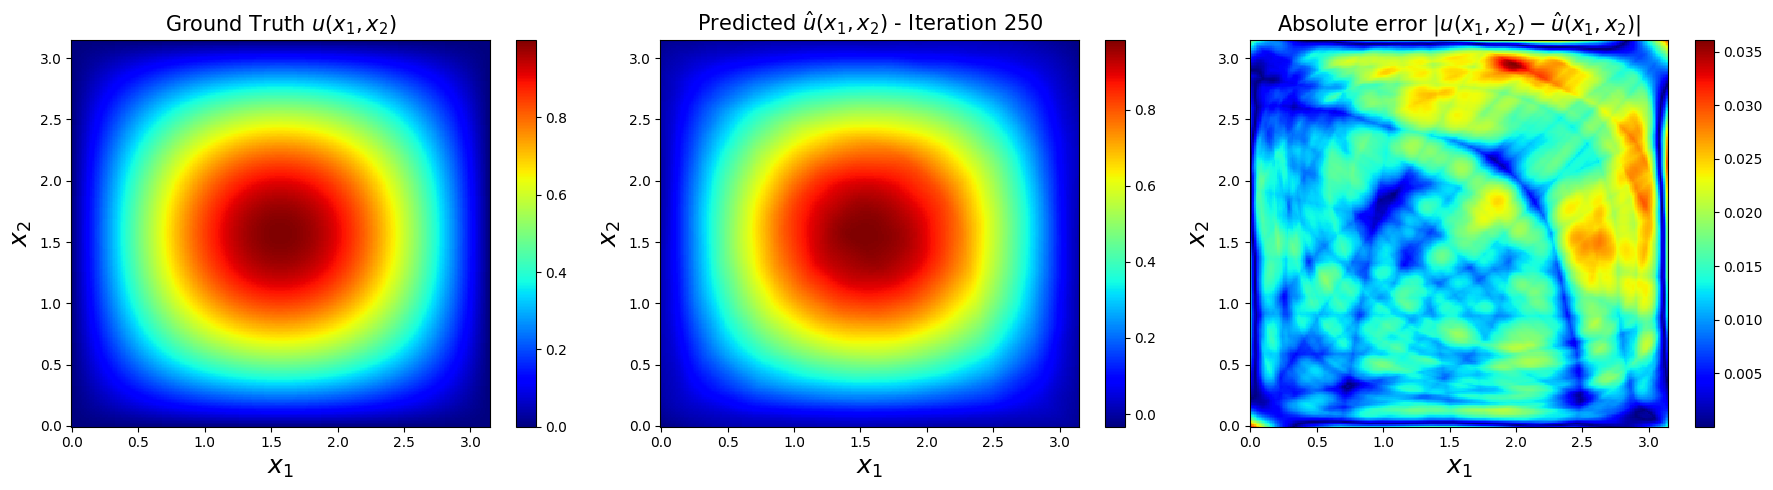

<Figure size 640x480 with 0 Axes>

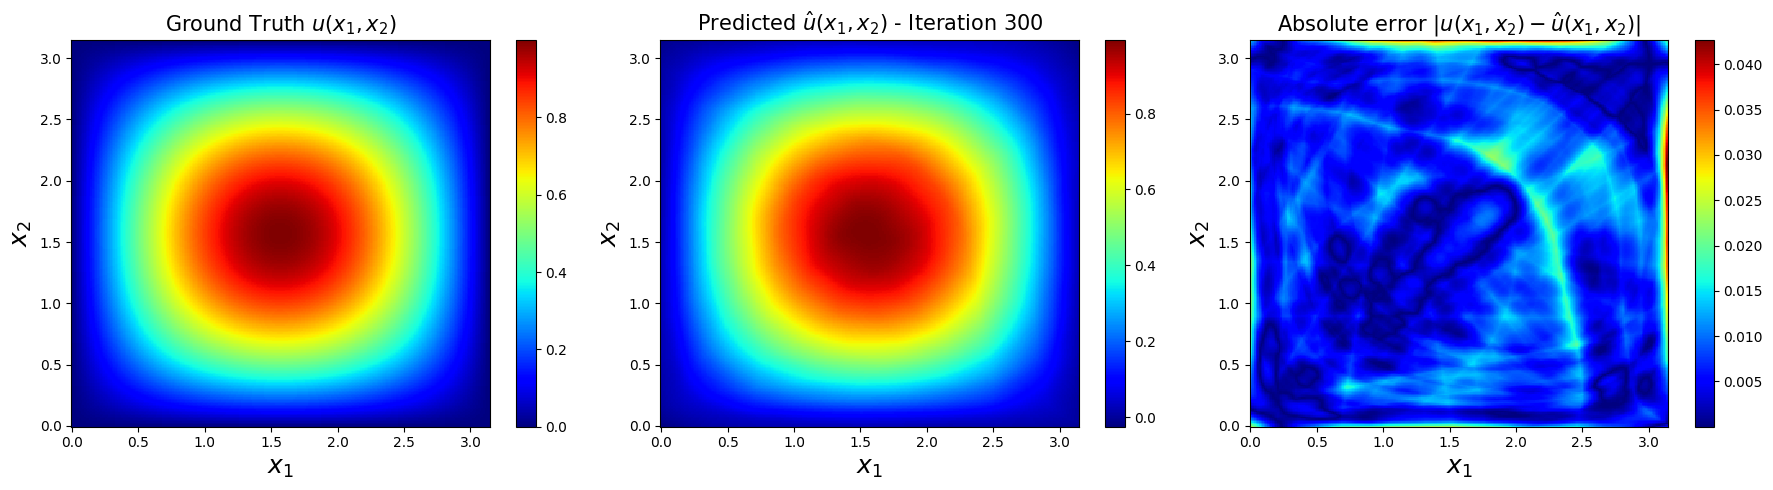

<Figure size 640x480 with 0 Axes>

In [18]:
# Specify number of grid points and number of dimensions
num_grid_pts = 256
nDim = 2

# Prepare test data
grids, axis_points = create_grid(num_grid_pts=num_grid_pts, n_dim=nDim)
X, Y = grids[0], grids[1]
x_1, x_2 = axis_points[0], axis_points[1]
X_u_test, lb, ub = prepare_test_data(X, Y)

# Analytical solution of the PDE
n = 1
m = 1
k = np.sqrt(np.pi ** 2 * (m ** 2 + n ** 2))
usol = np.sin(n * X) * np.sin(m * Y)

# Flatten the solution
u_true = usol.flatten()[:, None]

# Number of training points and collocation points
N_u = 500  # Total number of data points for 'u', used to train the model on boundary conditions
N_f = 10000  # Total number of collocation points for training the physics-informed part of the model in the domain

# Prepare training data
X_f_train_np_array, X_u_train_np_array, u_train_np_array = prepare_training_data(N_u, N_f, lb, ub, usol, X, Y)

# Convert numpy arrays to PyTorch tensors and move to GPU (if available)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)  # Collocation points
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)  # Boundary condition points
u_train = torch.from_numpy(u_train_np_array).float().to(device)  # Boundary condition values
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)  # Test data for boundary conditions
u = torch.from_numpy(u_true).float().to(device)  # True solution values (ground truth for testing)
f_hat = torch.zeros(X_f_train.shape[0], 1).to(device)  # Zero tensor for the physics equation residual

# Neural network architecture - Input layer with 2 nodes, 4 hidden layers with 200 nodes, and
# an output layer with 1 node
layers = np.array([2, 200, 200, 200, 200, 1])
PINN = HelmholtzPINN(layers)

# Move the model to the GPU (if available)
PINN.to(device)

# Print the neural network architecture
print(PINN)

# Store the neural network parameters for optimization
params = list(PINN.parameters())

# Optimizer setup
adam_optimizer = optim.Adam(PINN.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6, amsgrad=False)
lbfgs_optimizer = optim.LBFGS(PINN.parameters(), max_iter=500, tolerance_grad=1e-5, tolerance_change=1e-9, history_size=100)

start_time = time.time()  # Start timer

# Adam optimization loop
adam_iter = 350

# Store training progress
train_losses = []
test_losses = []
train_maes = []
test_maes = []
steps = []

for i in range(adam_iter):
    # Forward pass for boundary condition points (train data)
    u_pred_train = PINN.forward(X_u_train)

    # Data loss (MSE between predicted and true boundary condition values)
    data_loss = PINN.loss_function(u_pred_train, u_train)  # Boundary condition loss

    # Physics loss (PDE residuals computed inside the domain)
    physics_loss = PINN.loss_PDE(X_f_train, k)  # Physics loss at collocation points

    # Total loss: sum of data loss (boundary) and physics loss (domain)
    train_loss = data_loss + physics_loss

    # Train MAE (L1 loss between predicted and true solution on boundary points)
    train_mae = PINN.l1loss_function(u_pred_train, u_train)

    # Zero gradient buffers
    adam_optimizer.zero_grad()

    # Backpropagate gradients
    train_loss.backward()

    # Update model parameters
    adam_optimizer.step()

    if i % 10 == 0:
        # Test the model on validation data
        u_pred_test = PINN.forward(X_u_test_tensor)

        # Test loss (MSE between predicted and true solution on test data)
        test_loss = PINN.loss_function(u_pred_test, u)

        # Compute test MAE (L1 loss between predictions and true solution on test data)
        test_mae = PINN.l1loss_function(u_pred_test, u)

        # Print current iteration details
        #print(f"Iteration {i}: Train Loss {train_loss.item()}, Test Loss {test_loss.item()}, "
        #      f"Train MAE {train_mae.item()}, Test MAE {test_mae.item()}")

        # Append the current values to track progress
        steps.append(i)
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_maes.append(train_mae.item())
        test_maes.append(test_mae.item())

    if i % 50 == 0:

        # Predict the solution
        _, u_pred, _ = PINN.test(X_u_test_tensor, u)

        # Visualize the current prediction
        solutionplot(u_pred, usol, x_1, x_2, i)

In [19]:
# L-BFGS optimization
lbfgs_optimizer.step(LBFGS_training)

# Test after L-BFGS optimization
error_vec, u_pred, _ = PINN.test(X_u_test_tensor, u)
print(f'L-BFGS Test Error: {error_vec.item()}')

# Total training time
elapsed = time.time() - start_time
print(f'Training time: {elapsed:.2f} seconds')

# Final test accuracy
error_vec, u_pred, _ = PINN.test(X_u_test_tensor, u)
print(f'Test Error: {error_vec:.5f}')

L-BFGS Test Error: 0.0019847434014081955
Training time: 54.32 seconds
Test Error: 0.00198


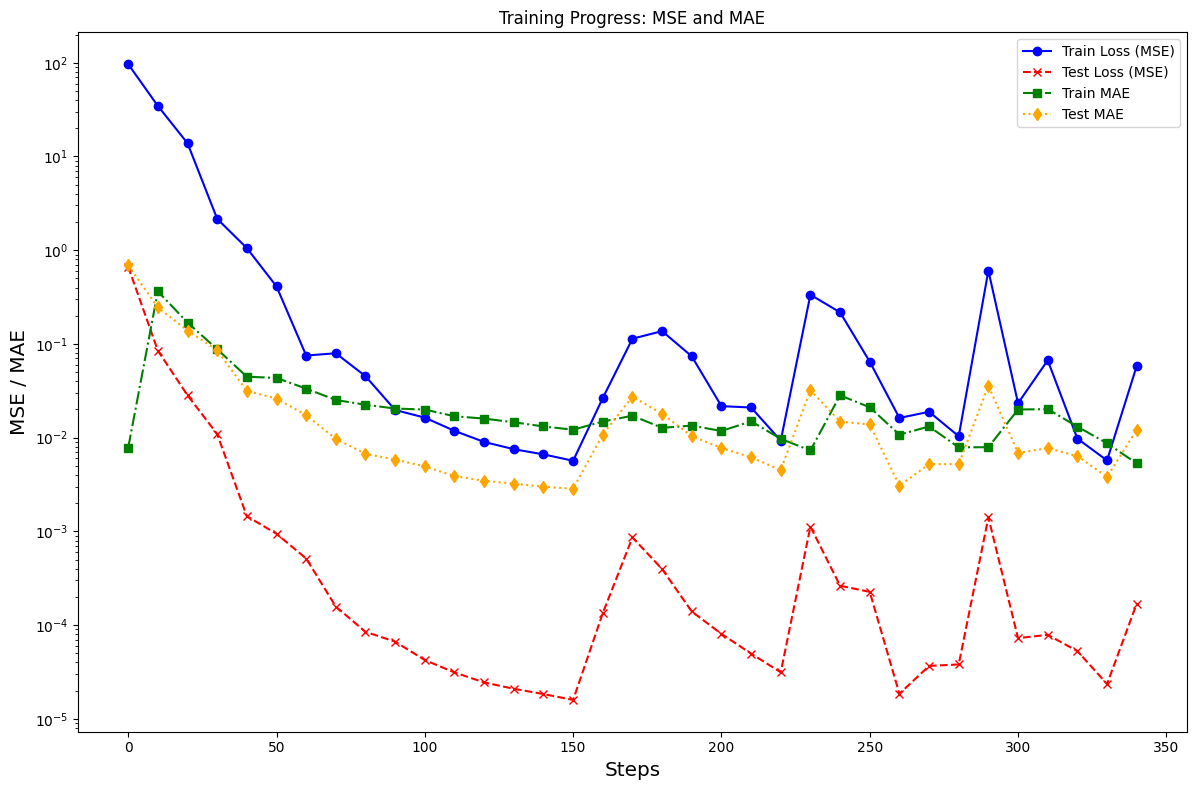

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot training progress
plot_training_progress(train_losses, test_losses, train_maes, test_maes, steps)

# 2D Example

Let's now examine the time-independent Gross-Pitaevskii Eigenvalue Problem
$$
\begin{cases}
-\Delta u +Vu+\eta |u|^2u=\lambda u, &\text{ in }U\\
u(x)=0, &\text{ on }\partial U
\end{cases}
$$

where $x=(x_1,x_2)\in\mathbb R^2$, $U\subset\mathbb R^2$ is bounded, $V(x)$ is a potential, and $\lambda$ is an eigenvalue.

We are interested in finding the ground eigenpair $(u,\lambda)$ with the smallest eigenvalue. In order to find the smallest eigenvalue, we use the energy method
\begin{align*}
\mathcal{E}=
\inf_{u\in H}
\left\{
\frac{1}{2}\int_\Omega |\nabla u|^2 +V|u|^2+\frac{\eta}{2}|u|^4
\right\},
\end{align*}
where
\begin{align*}
H=\left\{
u\in H_0^1:
\|u\|_{L^2}=1
\right\}.
\end{align*}

For convenience, we define
\begin{align*}
\mathcal{E}(u):= \left\{
\frac{1}{2}\int_\Omega |\nabla u|^2 +V|u|^2+\frac{\eta}{2}|u|^4
\right\},
\end{align*}

then the ground state is defined by
\begin{align*}
u=\text{argmin}_{u\in H} \mathcal{E}(u).\\
\end{align*}

As discussed, PDE problems can be solved through neural networks using PINNs:
if we have a PDE problem $\mathcal{P}(u)=0$, PINN method is to find the minimizer of
\begin{align*}
\mathcal{R}=\frac{1}{N}\sum_{k=1}^{N}
|\mathcal{P}(u(x_k))|^2
\end{align*}
with the given data points $x=[x_1,x_2,\dots, x_N]$.

Because our eigenvalue problem has two solutions, the ground state $u$ and the smallest eigenvalue $\lambda$, the problem will be $\mathcal{P}(u,\lambda)=0$. With this, if PINN method is used, the goal is to minimize
\begin{align*}
\mathcal{R}=\frac{1}{N}\sum_{k=1}^{N}
|\mathcal{P}(u(x_k)),\lambda|^2
\end{align*}

However, this minimization can give us multiple ground states with multiple eigenvalues as there is no restriction that $\lambda$ should be the smallest one. As we want to solve ground eigenpair problem, the PINN method might not return the ground state with the smallest eigenvalue.